In [69]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import os
from glob import glob
from evaluate import compute_sim, evaluate, l2norm_numpy

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

infer_dirs = [
    '/Users/macbook/Downloads/b5_768_sgd_lsep0.1_632',
    '/Users/macbook/Downloads/b5_768_adam_lsep0.1_657'
][1:]

infer_dirs = glob('infer/*')[:]
# infer_dirs = infer_dirs[1:]
weights = [0.2, 0.1, 0.1, 0.7]
weights = [1.0] * len(infer_dirs)

submit_file = f'submission.csv'
if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

norm=True
method = 'cat'

def get_emb(infer_dirs, subset, weights):
    li = []
    for infer_dir in infer_dirs:
        embs = pickle_load(f"{infer_dir}/{subset}_emb.pkl")
        li.append(embs)

    if len(li) == 1:
        return li[0]

    print(f'Ensemble from {infer_dirs}')
    li0 = li[0]
    di = {}
    for k in li0.keys():
        di[k] = []
        for i in range(len(li)):
            e = li[i][k]
            if norm:
                e *= weights[i]
                e = e / np.linalg.norm(e)
            di[k].append(e)
        
        if method == 'cat':
            di[k] = np.concatenate(di[k], 0)
        else:
            # Mean
            di[k] = np.mean(di[k], 0)

    return di

train_embs = get_emb(infer_dirs, 'train', weights)
test_embs = get_emb(infer_dirs, 'test', weights)
val_embs = get_emb(infer_dirs, 'val', weights)
train_df = pd.read_csv('data/train_kfold.csv')

# train_embs = l2norm(train_embs)
# test_embs = l2norm(test_embs)
# val_embs = l2norm(val_embs)

len(train_embs) + len(val_embs)

Ensemble from ['infer\\b5_768_adam_lsep0.1_657', 'infer\\b5_768_autoaug', 'infer\\b5_768_m0.5', 'infer\\b5_768_randaug', 'infer\\b7']
Ensemble from ['infer\\b5_768_adam_lsep0.1_657', 'infer\\b5_768_autoaug', 'infer\\b5_768_m0.5', 'infer\\b5_768_randaug', 'infer\\b7']
Ensemble from ['infer\\b5_768_adam_lsep0.1_657', 'infer\\b5_768_autoaug', 'infer\\b5_768_m0.5', 'infer\\b5_768_randaug', 'infer\\b7']


51033

In [70]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

In [73]:
from evaluate import compute_sim, evaluate, map_per_image, compute_simv2
from evaluate import *

score, val_sim_df = evaluate(train_df, train_embs, val_embs, norm=True)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
score

100%|██████████| 10207/10207 [00:07<00:00, 1312.68it/s]


0.3218526501420593

In [72]:
from evaluate import dict2list
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))
print(train_v.shape, test_v.shape)
train_v = l2norm_numpy(train_v)
test_v = l2norm_numpy(test_v)
train_ids = np.unique([train_map[x] for x in train_k])
allowed = []
for i, k in enumerate(test_k):
    if train_map[k] in train_ids:
        allowed.append(i)
test_k, test_v = [test_k[i] for i in allowed], [test_v[i] for i in allowed]
cosines = np.matmul(test_v, train_v.T)

(40826, 2560) (10207, 2560)


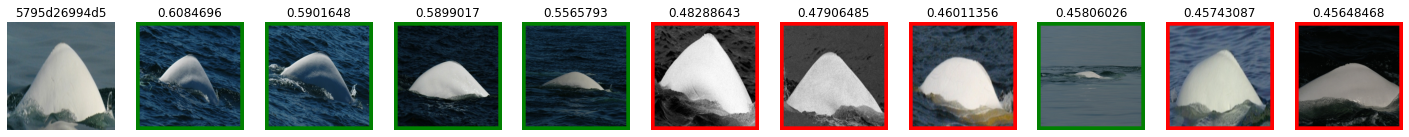

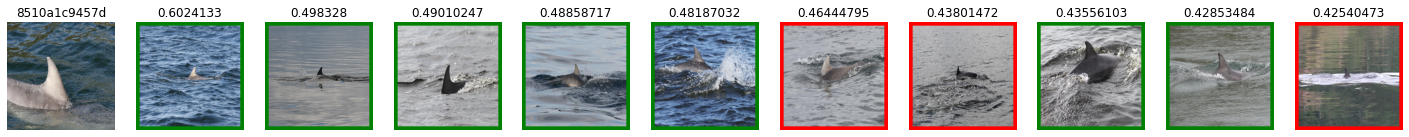

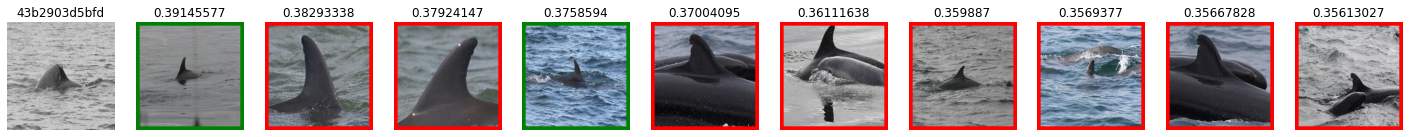

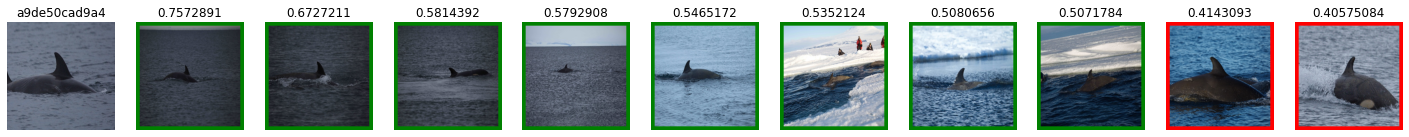

In [74]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.1:
        sort_idx = np.argsort(-scores)
        topk = [train_k[j] for j in sort_idx[:10]]
        topk_score = [scores[j] for j in sort_idx[:10]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        c+=1
        imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
        for k, l in zip(topk, topk_id):
            im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
            im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
            imgs.append(im)
        # Show image
        fig = plt.figure(figsize=(25, 4))
        columns = 11
        rows = 1
        for i2 in range(0, columns*rows):
            fig.add_subplot(rows, columns, i2+1)
            plt.title(f'{gt}' if i2 == 0 else topk_score[i2 - 1])
            plt.imshow(imgs[i2])
            plt.axis('off')
        
        plt.show()
        
    if c == 4:
        break
    

In [77]:
# val_sim_df

sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs, thr=0.5, norm=True)
sim_df[["image", "predictions"]].to_csv('submission.csv', index=False)
sim_df.head()   

100%|██████████| 27956/27956 [00:25<00:00, 1109.06it/s]


,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 new_individual 5b1c986551e4 574bd...
1,00150406ce5395.jpg,2280b5fcc6c2 new_individual 46d7e6928a69 8b23c...
2,002e8dd5f03476.jpg,3ab9313cbb32 new_individual fba54a4061f8 8b5c8...
3,00408e82bc01f3.jpg,6642e34b23c8 new_individual 356bfeac5626 135ce...
4,0063923659a874.jpg,new_individual d8494dbeeee2 8ff9204b05e7 88f17...


In [79]:
# assert False
from sklearn.neighbors import NearestNeighbors
n_neighbors = 100
knn = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine')

train_k, train_v = dict2list({**train_embs, **val_embs})
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [80]:
distances, idxs = knn.kneighbors(test_v, n_neighbors, return_distance=True)

In [81]:
from tqdm import tqdm

test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

100%|██████████| 27956/27956 [00:09<00:00, 2838.08it/s]


1      552
28     526
27     519
34     513
32     510
      ... 
95      32
97      22
99      21
98      19
100      8
Name: image, Length: 100, dtype: int64

In [82]:
predictions = {}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence >= 0.5:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(submit_file,index=False)
predictions.head()

100%|██████████| 27956/27956 [00:00<00:00, 482034.94it/s]


,image,predictions
0,7d0f46dd5f4108.jpg,982224d06f8c new_individual 3d5a4dd24d21 910b9...
1,dd806b5d0f42e1.jpg,13e453fd9598 new_individual 8a970b80da15 783f3...
2,7a785b700b0339.jpg,c93996835aa8 new_individual d36d5a07500f 958e2...
3,d846a86edded63.jpg,03a3bbaeed84 new_individual fc3c6210e761 2ac23...
4,3c52966f74d2ad.jpg,978520860ceb new_individual 8b18a0a74b82 cfd34...


In [83]:
sim_df = predictions
sim_df = sim_df.sort_values('image')

s655_df = pd.read_csv(r'c:\Users\msi\Downloads\submission.csv')
s655_df= s655_df.sort_values('image')
(sim_df.predictions.values == s655_df.predictions.values).mean()

0.01355701817141222